In [1]:
import time
from copy import deepcopy

import IPython.display as IPd
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np

In [2]:

import stg_energy.fig3_active_subspaces.viz as viz
from pyloric import simulate, summary_stats
from stg_energy.common import col, svg
import pandas as pd
import torch
from stg_energy.fig3_active_subspaces.helper_functions import nth_argmax, nth_argmin, obtain_max_in_dimension
from stg_energy import check_if_close_to_obs


# Figure 2

In [3]:
pd.options.display.max_columns=999

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
PANEL_A = "../svg/panel_a_supp_current.svg"
PANEL_B = "../svg/panel_b_supp_current.svg"
PANEL_C = "../svg/panel_c_supp_current.svg"
PANEL_D = "../svg/panel_d_supp_current.svg"

In [6]:
theta = pd.read_pickle("../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_circuit_parameters.pkl")
x = pd.read_pickle("../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_simulation_outputs.pkl")
seeds = np.load("../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_seeds.npy")

theta_np = theta.to_numpy()
x_np = x.to_numpy()

# Panel A: Histogram for total energy

In [7]:
sims_total = pd.read_pickle("../../../results/energy_measure_comparison/posterior_total.pkl")
all_total_energies = sims_total["energies"].to_numpy() / 10 / 1.6

In [8]:
# summed_energies_per_spike = np.sum(np.asarray(all_energies_per_spike), axis=1)
summed_energies_total = np.sum(np.asarray(all_total_energies), axis=1)

In [9]:
summed_energies_total

array([22.02134252, 23.85566053, 19.76136732, ..., 25.33556263,
       20.41035845, 35.60915965])

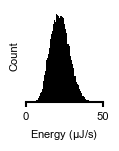

In [107]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.0, 1.2))


    _ = ax.hist(summed_energies_total, range=[0, 50], bins=100, color="k")
    # ax[3].set_ylabel('Count')
    ax.tick_params(axis="both", which="major")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.axes.get_yaxis().set_ticks([])
    ax.set_ylabel("Count")
    plt.subplots_adjust(wspace=0.3)

    ax.set_xlim([0, 50])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_xlabel("Energy ($\mu$J/s)")
    ax.set_xticks([0, 50])

    plt.savefig(PANEL_A, facecolor="None", transparent=True)
    plt.show()

# Panel B: constrainment

In [11]:
cols_hex = [
    "#1b9e77",
    "#d95f02",
    "#7570b3",
    "#e7298a",
    "#66a61e",
    "#e6ab02",
    "#a6761d",
    "#666666",
    "#1b9e77",
    "#d95f02",
    "#7570b3",
    "#e7298a",
    "#66a61e",
    "#e6ab02",
    "#a6761d",
    "#666666",
    "#1b9e77",
    "#d95f02",
    "#7570b3",
    "#e7298a",
    "#66a61e",
    "#e6ab02",
    "#a6761d",
    "#666666",
]
cols = np.asarray(cols_hex)

In [12]:
energies_tt = torch.as_tensor(all_total_energies, dtype=torch.float32)
# x_tt = torch.as_tensor(x_np, dtype=torch.float32)

In [13]:
num_test = 1000

theta_test = torch.as_tensor(theta_np[:num_test], dtype=torch.float32)
theta_train = torch.as_tensor(theta_np[num_test:], dtype=torch.float32)

In [14]:
train_energy = torch.as_tensor(
    torch.sum(energies_tt[num_test:], dim=1).unsqueeze(1), dtype=torch.float32
)
test_energy = torch.as_tensor(
    torch.sum(energies_tt[:num_test], dim=1).unsqueeze(1), dtype=torch.float32
)

In [15]:
summed_energies = summed_energies_total

In [16]:
inds = np.argsort(summed_energies)

In [17]:
sorted_energies = summed_energies[inds]
num_vals = sorted_energies.shape[0]
quantile = 0.02
one_percent_quantile = int(num_vals * quantile)
ninenine_percent_quantile = int(num_vals * (1-quantile))
one_percent_energy = sorted_energies[one_percent_quantile]
ninenine_percent_energy = sorted_energies[ninenine_percent_quantile]

In [18]:
min_energy_condition = summed_energies < one_percent_energy
max_energy_condition = summed_energies > ninenine_percent_energy

In [19]:
min_energy_theta = theta_np[min_energy_condition]
max_energy_theta = theta_np[max_energy_condition]

min_energy_energies = summed_energies[min_energy_condition]
max_energy_energies = summed_energies[max_energy_condition]

In [20]:
std_of_min_energy = np.std(min_energy_theta, axis=0)
std_of_all_samples = np.std(theta_np, axis=0)

In [21]:
stds_fraction = 1 - (std_of_min_energy / std_of_all_samples)

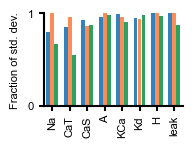

In [106]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars_cosyne(
        1.0 - deepcopy(torch.as_tensor(stds_fraction)),
        ylim=[0.0, 1.0],
        figsize=(1.8, 1.2),
        ylabel="Fraction of std. dev.",
        title=None,
        title_x_offset=-1.1,
        title_y_offset=0.1,
        legend_y_offset=0.3,
        legend=False,
        yticks=[0, 1],
        ylabelpad=5.5,
        rotation=90,
        spacing=0.23
    )
    plt.savefig(PANEL_B, facecolor="None", transparent=False)
    plt.show()

# Panel C

In [23]:
from pyloric import create_prior
from sklearn.linear_model import LinearRegression

prior = create_prior()

In [24]:
energies = torch.as_tensor(all_total_energies, dtype=torch.float32)

In [25]:
num_test = 500

test_params = theta_np[:num_test]
train_params = theta_np[num_test:]
mean_params = prior.numerical_prior.mean.numpy()
std_params = prior.numerical_prior.stddev.numpy()

mean_params = obtain_max_in_dimension(mean_params)
std_params = obtain_max_in_dimension(std_params)

train_params_norm = (train_params - mean_params) / std_params
test_params_norm = (test_params - mean_params) / std_params

In [26]:
train_energy_ABPD = torch.sum(torch.as_tensor(energies.numpy())[num_test:], dim=1).unsqueeze(1)
test_energy_ABPD = torch.sum(torch.as_tensor(energies.numpy())[:num_test], dim=1).unsqueeze(1)
mean_energy = torch.mean(train_energy_ABPD)
std_energy = torch.std(train_energy_ABPD)
train_energy_ABPD_norm = (train_energy_ABPD - mean_energy) / std_energy
test_energy_ABPD_norm = (test_energy_ABPD - mean_energy) / std_energy

regressor = LinearRegression()
fitted_reg = regressor.fit(train_params_norm, train_energy_ABPD_norm)
predictions = fitted_reg.predict(test_params_norm)
coeff = np.asarray([fitted_reg.coef_[0]])
coeff = coeff / np.linalg.norm(coeff)

In [27]:
coeff

array([[ 0.1727502 ,  0.2202642 ,  0.2110698 , -0.10814327,  0.01554409,
        -0.04977924, -0.01045543, -0.04654298,  0.12997827,  0.2866243 ,
         0.20686424, -0.08117511, -0.00668267, -0.05561426,  0.00904026,
        -0.02317927,  0.3086239 ,  0.38215867,  0.56343347, -0.24364972,
        -0.2739956 , -0.08248641,  0.01132163, -0.04305229,  0.02503261,
        -0.00919805, -0.01153536,  0.03876711,  0.00540328, -0.01854856,
         0.05930854]], dtype=float32)

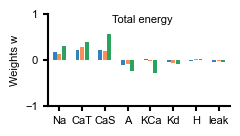

In [105]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    viz.py_sensitivity_bars_cosyne(
        torch.as_tensor(coeff)[0],
        ylim=[-1, 1.0],
        figsize=(2.35, 1.2),
        ylabel='Weights w',
        plot_labels=True,
        legend=False,
        title='Total energy',
        yticks=[-1, 0, 1]
    )
    plt.savefig(PANEL_C, facecolor="None", transparent=False)
    plt.show()

# Panel D

In [29]:
sims_p = "../../../results/simulation_data_Tube_MLslurm_cluster/"

In [30]:
theta_11_11_close = pd.read_pickle(sims_p+"close_to_xo_circuit_parameters.pkl")
# x_11_11_close = pd.read_pickle(sims_p+"close_to_xo_simulation_outputs.pkl")

x_11_11_close = pd.read_pickle("../../../results/energy_measure_comparison/posterior_total.pkl")

seeds_11_11_close = np.load(sims_p+"close_to_xo_seeds.npy")

theta_11_11_close_np = theta_11_11_close.to_numpy()
x_11_11_close_np = x_11_11_close.to_numpy()

In [31]:
theta_27_11 = pd.read_pickle(sims_p+"simulate_27deg_R4_predictives_at_11deg_notau/data/all_circuit_parameters.pkl")
x_27_11 = pd.read_pickle(sims_p+"simulate_27deg_R4_predictives_at_11deg_notau/data/all_simulation_outputs.pkl")
seeds_27_11 = np.load(sims_p+"simulate_27deg_R4_predictives_at_11deg_notau/data/all_seeds.npy")

theta_27_11_np = theta_27_11.to_numpy()
x_27_11_np = x_27_11.to_numpy()

In [32]:
theta_27_27 = pd.read_pickle(sims_p+"simulate_27deg_R4_predictives_at_27deg_notau/data/all_circuit_parameters.pkl")
x_27_27 = pd.read_pickle(sims_p+"simulate_27deg_R4_predictives_at_27deg_notau/data/all_simulation_outputs.pkl")
seeds_27_27 = np.load(sims_p+"simulate_27deg_R4_predictives_at_27deg_notau/data/all_seeds.npy")

theta_27_27_np = theta_27_27.to_numpy()
x_27_27_np = x_27_27.to_numpy()

In [33]:
condition_rejection_nan = pd.read_pickle(sims_p+"simulate_11deg_R3_predictives_at_27deg_notau_only_close/data/simulation_outputs/sim_0.pkl")
condition_rejection_nan_np = condition_rejection_nan.to_numpy()

condition_rejection = np.invert(np.any(np.isnan(condition_rejection_nan_np), axis=1))

x_11_11_rejection_nan = x_11_11_close[condition_rejection]
x_11_11_rejection_nan = x_11_11_rejection_nan.loc[x_11_11_rejection_nan['pyloric_like']['Circuit'] == 1.0]
x_11_11_rejection_nan_np = x_11_11_close_np[condition_rejection]
theta_11_11_rejection_nan_np = theta_11_11_close_np[condition_rejection]

In [34]:
xo11 = np.load("../../../results/experimental_data/xo_11deg.npy")
xo27 = np.load("../../../results/experimental_data/xo_27deg.npy")

npz = np.load("../../../results/experimental_data/trace_data_845_082_0044.npz")
t = npz["t"]

In [35]:
close_at_11 = check_if_close_to_obs(x_27_11_np)
close_at_27 = check_if_close_to_obs(x_27_27_np, xo=xo27[:15])
close_at_both = np.asarray([c1 and c2 for c1, c2 in zip(close_at_11, close_at_27)])

x_27_27_close = x_27_27[close_at_both]
theta_27_27_close = theta_27_27[close_at_both]
seeds_27_27_close = seeds_27_27[close_at_both]

x_27_27_close_np = x_27_27_np[close_at_both]
theta_27_27_close_np = theta_27_27_np[close_at_both]

x_27_11_close = x_27_11[close_at_both]
theta_27_11_close = theta_27_11[close_at_both]
seeds_27_11_close = seeds_27_11[close_at_both]

x_27_11_close_np = x_27_11_np[close_at_both]
theta_27_11_close_np = theta_27_11_np[close_at_both]

In [36]:
x_27_11_close.index = np.arange(len(x_27_11_close))
theta_27_11_close.index = np.arange(len(theta_27_11_close))

x_27_27_close.index = np.arange(len(x_27_27_close))
theta_27_27_close.index = np.arange(len(theta_27_27_close))

In [37]:
theta_27_11_close

AB/PD                                                        \
              Na       CaT       CaS          A        KCa          Kd   
0     304.990326  1.789204  3.997164   4.001170   7.991362   41.313229   
1     408.176056  7.125993  5.481329   7.802814  12.115567   93.069473   
2     109.887695  3.397462  5.508301  24.641094  11.342633  131.047089   
3     247.452057  1.730958  1.558352   9.972960   4.740343   44.698849   
4      80.258926  1.319289  3.109921  16.975822   8.556080  113.675949   
...          ...       ...       ...        ...        ...         ...   
6126  127.028465  1.315958  4.736544   8.775309  11.608871   70.885719   
6127  333.460846  2.698201  5.137254  15.445150  11.699034   73.369278   
6128  301.265320  4.964927  3.280591   0.985764  10.116987  108.212433   
6129  337.023224  5.326642  7.178200  59.952869  14.620828  139.333344   
6130  401.557037  3.434575  1.499387  24.603209   3.843304   81.871033   

                                  LP                                  \
             H      Leak          Na       CaT        CaS          A   
0     0.002192  0.006065  143.944977  0.158747   8.507117  54.347969   
1     0.000656  0.001899  103.531601  0.617423   5.530856  30.084188   
2     0.004622  0.000486   79.312943  1.699502   2.589211  17.879963   
3     0.002328  0.008061  104.176003  0.541186   7.317458  57.440533   
4     0.000630  0.009864  156.906158  0.762273   5.251544  42.963989   
...        ...       ...         ...       ...        ...        ...   
6126  0.000231  0.004543  102.683090  0.287959   3.561882  23.816483   
6127  0.001747  0.005577   67.204430  0.516356   5.210397  55.740448   
6128  0.000006  0.008537   63.884159  1.103435   4.929003  22.421890   
6129  0.000978  0.005662  187.550583  0.139048  11.591822  58.700405   
6130  0.002610  0.007635  139.463181  0.578104   4.907999  49.993027   

                                                        PY             \
           KCa          Kd         H      Leak          Na        CaT   
0     4.330705  122.133148  0.042896  0.014669  289.703857  11.523194   
1     5.449278   56.968632  0.038606  0.018213  594.720337  10.626469   
2     2.742831   69.734612  0.053269  0.028687  138.640289   3.995982   
3     7.649863   70.249985  0.043699  0.014704  272.211914   5.709944   
4     4.737316   98.462387  0.041773  0.010495  478.501740   3.287252   
...        ...         ...       ...       ...         ...        ...   
6126  1.007531   58.855659  0.057020  0.010463  288.379211   3.192037   
6127  0.838758   45.124386  0.035484  0.013282  299.198303   7.311912   
6128  8.162315  101.210228  0.029388  0.027117  124.424774   6.287436   
6129  1.885499   94.667984  0.054415  0.018586  573.252380   1.889885   
6130  3.120297   66.642189  0.058204  0.025525  307.446533   8.150930   

                                                                     \
           CaS          A       KCa          Kd         H      Leak   
0     3.412572  31.251215  3.112689  141.121536  0.028108  0.027426   
1     1.999339  33.684559  2.135439  117.302696  0.021839  0.024636   
2     2.122867  31.055859  0.480947  125.208603  0.022984  0.003262   
3     2.545594  33.940456  2.366876  118.905510  0.035291  0.027760   
4     3.523968  34.463661  1.637747   69.111549  0.047965  0.034084   
...        ...        ...       ...         ...       ...       ...   
6126  3.749928  40.938690  2.097486   81.657852  0.050458  0.036162   
6127  3.697595  47.332119  2.431706   93.040657  0.025101  0.026172   
6128  3.828130  30.586130  3.825820  147.203522  0.015524  0.015633   
6129  3.260670  32.413410  0.092413  148.334717  0.019156  0.015809   
6130  2.675313  30.622292  2.466575  120.781609  0.031773  0.037647   

       Synapses                                                         \
          AB-LP      PD-LP      AB-PY      PD-PY      LP-PD      LP-PY   
0     -8.933640 -11.397654 -10.403267  -8.622699  -7.288735 -13.991539   
1     -8.460548

# Resimulate, at 11 degree, those configurations that are fit at 27

In [38]:
from pyloric import simulate, create_prior, summary_stats
from multiprocessing import Pool

In [59]:
def my_simulator(params_with_seeds):
    p1 = create_prior()
    pars = p1.sample((1,))
    column_names = pars.columns

    parameter_set_pd = pd.DataFrame(
        np.asarray([params_with_seeds[:-1]]), columns=column_names
    )
    out_target = simulate(
        parameter_set_pd.loc[0],
        seed=int(params_with_seeds[-1]),
        dt=0.025,
        t_max=11000,
        temperature=283,
        noise_std=0.001,
        track_energy=True,
        energy_measure="current"
    )
    custom_stats = {
        "plateau_durations": True,
        "num_bursts": True,
        "num_spikes": True,
        "energies": True,
        "energies_per_burst": True,
        "energies_per_spike": True,
        "pyloric_like": True,
    }
    return summary_stats(out_target, stats_customization=custom_stats, t_burn_in=1000)

In [72]:
data_np = theta_27_11_close.to_numpy()
params_with_seeds = np.concatenate((data_np, seeds_27_11_close[:, None]), axis=1)

In [73]:
with Pool(16) as pool:
    start_time = time.time()
    data1 = pool.map(my_simulator, params_with_seeds)
    print("Simulation time", time.time() - start_time)

sims_out1 = pd.concat(data1, ignore_index=True)
sims_out1.to_pickle("../../../results/energy_measure_comparison/posterior_total_configs_fitted_at_27_11_close.pkl")

Simulation time 577.739413022995


In [74]:
x_27_11_current_based_energy = pd.read_pickle("../../../results/energy_measure_comparison/posterior_total_configs_fitted_at_27_11_close.pkl")


In [75]:
all_total_energies_11 = x_11_11_close['energies'].to_numpy()
all_total_energies_27 = x_27_11_current_based_energy['energies'].to_numpy()
all_total_energies_rejection = x_11_11_rejection_nan['energies'].to_numpy()

In [76]:
summed_energies_total_11 = np.sum(np.asarray(all_total_energies_11), axis=1) / 10 / 1.6 # per second, micro-Joule
summed_energies_total_27 = np.sum(np.asarray(all_total_energies_27), axis=1) / 10 / 1.6
summed_energies_total_27_rejection = np.sum(np.asarray(all_total_energies_rejection), axis=1) / 10 / 1.6

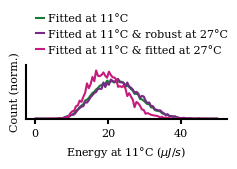

In [77]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 1, figsize=(2.6, 0.7))

    hist_vals_11 = ax.hist(summed_energies_total_11, range=(0, 50), bins=100, color='w', density=True)
    hist_vals_27_rob = ax.hist(summed_energies_total_27_rejection, range=(0, 50), bins=100, color='w', density=True)
    hist_vals_27 = ax.hist(summed_energies_total_27, range=(0, 50), bins=100, color='w', density=True)

    hist_diff = hist_vals_11[1][1] - hist_vals_11[1][0]
    line11 = ax.plot(hist_vals_11[1][:-1]+hist_diff/2, hist_vals_11[0], c='#1b7837')
    line27robust = ax.plot(hist_vals_27_rob[1][:-1]+hist_diff/2, hist_vals_27_rob[0], c='#762a83')
    line27 = ax.plot(hist_vals_27[1][:-1]+hist_diff/2, hist_vals_27[0], c='#c51b7d')
    ax.set_xlabel('Energy at 11°C ($\mu J/s$)')
    ax.set_ylabel('Count (norm.)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim([0, 0.09])
    ax.set_yticks([])

    plt.legend((line11[0], line27robust[0], line27[0]), ('Fitted at 11°C', 'Fitted at 11°C & robust at 27°C', 'Fitted at 11°C & fitted at 27°C'), bbox_to_anchor=(0.0, 1.0, 0.5, 0.5), handlelength=0.8, handletextpad=0.3)

    plt.savefig(PANEL_D, facecolor='None', transparent=True)

# Assemble figure

In [98]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [120]:
from svgutils.compose import *
import svgutils.transform as sg

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("20.3cm", "3.8cm",

    Panel(
          SVG(PANEL_A).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("a", 0.0*factor_svg, 0.7*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 2.3*factor_svg),
           
    Panel(
          SVG(PANEL_B).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("b", -1*factor_svg, 1.5*factor_svg, **kwargs_text),
    ).move(22*factor_svg, 1.5*factor_svg),
    
    Panel(
          SVG(PANEL_C).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("c", 0.0*factor_svg, 1.5*factor_svg, **kwargs_text),
    ).move(57*factor_svg, 1.5*factor_svg),
           
    Panel(
          SVG(PANEL_D).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("d", 0.0*factor_svg, 3.7*factor_svg, **kwargs_text),
    ).move(100*factor_svg, -.7*factor_svg),

)

f.save("../fig/fig1_supp_current_results.svg")
svg('../fig/fig1_supp_current_results.svg')